# Imports

In [1]:
#Imports
%matplotlib widget
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import scipy
import datetime
import networkx as nx
import misc
import math
import random
import SmallBucket
import BigBucket
import RandomWarmUp1
import RandomWarmUp2
import StaticDynamic

# Data Generation

In [2]:
#Create empty graph
G = nx.Graph()

In [3]:
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

G.add_edges_from([
    (0,1),
    (1,2),
    (2,3),
    (3,4),
    (4,5),
    (5,6),
    (6,7),
    (7,8),
    (8,9),
    (9,0),

    (0,2),
    (0,3),
    (0,4),
    (1,3)
])

In [4]:
G = nx.Graph()

In [5]:
G = misc.createRandomGraph(size=30, density=0.4, maxDegree=1000)
misc.graphInfo(G)

Chosen max degree does not fall into range (12, 36) permitted by other parameters, so picking closest value instead
Nodes: 37
Edges: 220
Density: 0.3303303303303303
Max Degree: 36
Average Degree: 11.891891891891891
Static Coloring uses 8 colors


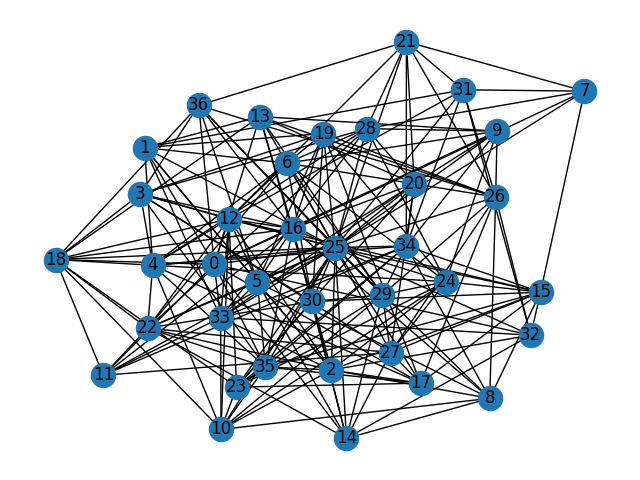

In [6]:
misc.draw(G)

# Common items

In [7]:
# Returns a coloring dictionary by combining the two available colorings
def getColoring() -> dict:
    coloring: dict = {}
    sColoring = staticColoring
    dColoring = DBB.getColoring()

    for node in G.nodes():
        coloring[node] = (sColoring[node], dColoring[node])
    return coloring

In [8]:
# Print the current situation of the leveled segment data structure
def printLevels():
    print("l: " + str(l))
    print("c: " + str(c))

# Algorithm Specific Methods

In [9]:
def removeEdge(s, t):
    if not G.has_edge(s, t):    # Potentially redundant
        print("Edge not present in graph")
        return
    G.remove_edge(s, t)
    if DBB.G.has_edge(s, t):
        DBB.removeEdge(s, t)
    updateStep()

def removeVertex(v):

    if not G.has_node(v):   # Potentially redundant
        print("Node not present in graph")
        return
    G.remove_node(v)
    DBB.removeVertex(v)
    updateStep()

def addEdge(s, t):

    if G.has_edge(s, t):    # Potentially redundant, but could be extended to also check if the vertices are present yet
        print("Edge already in the graph")
        return
    if (not G.has_node(s) or not G.has_node(t)):
        print("Not all nodes present in graph yet")
        return

    G.add_edge(s, t)
    DBB.G.add_edge(s, t)       # Add edge to G' directly, without running the dynamic algorithm

    # Increase recent degree of endpoints
    G.nodes[s]['recentDegree'] += 1
    G.nodes[t]['recentDegree'] += 1

    updateStep()               # Run update step in which the static algorithm is potentially ran

    if DBB.G.has_edge(s, t):    # If edge still in G' after update step, run dynamic algorithm
        DBB.removeEdge(s, t)
        dynamicBlackBox(s, t) 

    # Add node with highest recent degree to active level node sets
    if G.number_of_nodes() > 0:
        rd = -1
        n = None
        for node in G.nodes():
            if G.nodes[node]['recentDegree'] > rd:
                rd = G.nodes[node]['recentDegree']
                n = node
        for level in levels:
            if level[1]:
                level[0].add(n)

def addVertex(v):
    if G.has_node(v):   # Potentially redundant, depending on the input used during the experiments
        print("Node already present in graph")
        return
    G.add_node(v)
    staticColoring[v] = 'L0C0'
    G.nodes[v]['recentDegree'] = 0
    DBB.addVertex(v)
    updateStep()

In [10]:
sda = StaticDynamic.StaticDynamicAlgo(G)

In [11]:
c1 = sda.getColoring()

sda.addEdge(7,9)

c2 = sda.getColoring()
misc.numberOfRecolors(c1, c2)

1

In [12]:
sda.getColoring()

{0: ('L0C3', 0),
 1: ('L0C1', 0),
 2: ('L0C3', 0),
 3: ('L0C3', 0),
 4: ('L0C2', 0),
 5: ('L0C4', 0),
 6: ('L0C3', 0),
 7: ('L0C1', 1),
 8: ('L0C7', 0),
 9: ('L0C2', 0),
 10: ('L0C5', 0),
 11: ('L0C6', 0),
 12: ('L0C1', 0),
 13: ('L0C5', 0),
 14: ('L0C6', 0),
 15: ('L0C2', 0),
 16: ('L0C2', 0),
 17: ('L0C5', 0),
 18: ('L0C4', 0),
 19: ('L0C6', 0),
 20: ('L0C3', 0),
 21: ('L0C2', 0),
 22: ('L0C5', 0),
 23: ('L0C7', 0),
 24: ('L0C1', 0),
 25: ('L0C0', 0),
 26: ('L0C1', 0),
 27: ('L0C4', 0),
 28: ('L0C4', 0),
 29: ('L0C2', 0),
 30: ('L0C1', 0),
 31: ('L0C3', 0),
 32: ('L0C4', 0),
 33: ('L0C2', 0),
 34: ('L0C1', 0),
 35: ('L0C6', 0),
 36: ('L0C5', 0)}

In [13]:
sda.printLevels()

l: 5
c: 1
Last Updated Level: 0
Max Level: 5


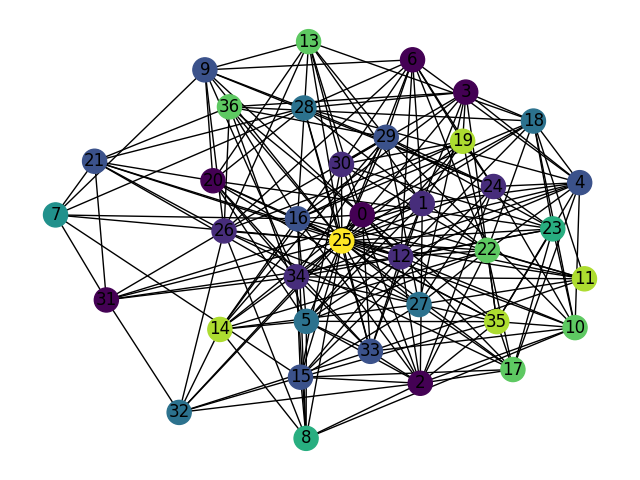

In [14]:
misc.draw(sda.G, sda.getColoring())

In [15]:
misc.numberOfColors(sda.getColoring())

9

In [ ]:
rwu2 = RandomWarmUp2.WarmUp2Algo(G)

In [ ]:
c1 = rwu2.getColoring()

rwu2.addEdge(7,9)

c2 = rwu2.getColoring()
misc.numberOfRecolors(c1, c2)

In [ ]:
rwu2.getColoring()

In [ ]:
rwu2.printLevels()

In [ ]:
misc.draw(rwu2.G, rwu2.getColoring())

In [ ]:
misc.numberOfColors(rwu2.getColoring())